In [1]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fmdtools.faultsim as fs
import fmdtools.resultdisp as rd
import quadpy
from IPython.display import HTML

In [2]:
from fmdtools.modeldef import FxnBlock
from fmdtools.modeldef import Flow
from fmdtools.modeldef import Model
from fmdtools.modeldef import m2to1
from fmdtools.modeldef import Component
from fmdtools.modeldef import SampleApproach

### Setting Node Positions

In [17]:
class Drone(Model):
    def __init__(self, params={}):
        super().__init__()
        self.params=params
        #add flows to the model
        self.add_flow('Force_ST', {})
        self.add_flow('Force_Lin', {})
        self.add_flow('Force_GR' , {})
        self.add_flow('Force_LG', {})
        self.add_flow('EE_1', {})
        self.add_flow('EEmot', {})
        self.add_flow('EEctl', {})
        self.add_flow('Ctl1', {})
        self.add_flow('DOFs', {})
        self.add_flow('Env1', {})
        # custom flows
        self.add_flow('Dir1', {})
        #add functions to the model
        flows=['EEctl', 'Force_ST']
        self.add_fxn('StoreEE',['EE_1', 'Force_ST'])
        self.add_fxn('DistEE', ['EE_1','EEmot','EEctl', 'Force_ST'])
        self.add_fxn('AffectDOF',['EEmot','Ctl1','DOFs','Force_Lin'])
        self.add_fxn('CtlDOF', ['EEctl', 'Dir1', 'Ctl1', 'DOFs', 'Force_ST'])
        self.add_fxn('Planpath', ['EEctl', 'Env1','Dir1', 'Force_ST'])
        self.add_fxn('Trajectory', ['Env1','DOFs','Dir1', 'Force_GR'] )
        self.add_fxn('EngageLand',['Force_GR', 'Force_LG'])
        self.add_fxn('HoldPayload',['Force_LG', 'Force_Lin', 'Force_ST'])
        self.add_fxn('ViewEnv', ['Env1'])
        
        self.construct_graph()
        #self.construct_graph(graph_pos = {'StoreEE': [0.13322414342899602, 0.21477632506511113],
 #'DistEE': [0.5896210930551233, -0.08591779042202319],
 #'AffectDOF': [0.4267774855331683, 0.4401963508136246],
 #'CtlDOF': [-0.5, 0.8660253882408142],
 #'Planpath': [-0.9396925568580627, 0.3420202136039734],
 #'Trajectory': [-0.7402574040187169, -0.6565140488613741],
 #'EngageLand': [0.02927033251370781, -0.3981198969531473],
 #'HoldPayload': [-0.5397160219633146, 0.5493088305815919],
 #'ViewEnv': [0.7660443782806396, -0.642787754535675]})

In [18]:
mdl = Drone()

As shown below, it can be difficult to make sense of a model structure using the default shell graph layout. We might instead want to see something that more closely approximates a flow chart of the system.

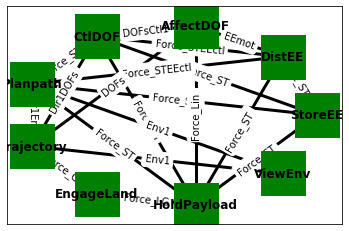

In [24]:
rd.graph.show(mdl.graph)

To set node positions, we can use ``rd.graph.set_pos()``, which lets one drag the nodes to their desired locations. If a model is sent to ``set_pos``, it will set those locations in the model going forward, though it is good practice to save node locations when one is done in the script or the model class file (they can be used as inputs to ``construct_graph()``.

In [20]:
%matplotlib qt
pos = rd.graph.set_pos(mdl)
pos

{'StoreEE': [-1.0787279392101061, -0.06903523859088145],
 'DistEE': [-0.361531174332526, -0.0935883732235363],
 'AffectDOF': [0.36541282312106205, -0.09674444529230719],
 'CtlDOF': [0.4664934329906758, 0.5822138245848214],
 'Planpath': [-0.7095750728126631, 0.8482786785038505],
 'Trajectory': [1.1006824683444765, -0.10423208715241583],
 'EngageLand': [0.8423521094741182, -0.8813666134484857],
 'HoldPayload': [-0.5857395187723944, -0.86974898769837],
 'ViewEnv': [1.1035500215472247, 0.9373523025760659]}

In [25]:
graph_pos = {'StoreEE': [-1.0787279392101061, -0.06903523859088145],
 'DistEE': [-0.361531174332526, -0.0935883732235363],
 'AffectDOF': [0.36541282312106205, -0.09674444529230719],
 'CtlDOF': [0.4664934329906758, 0.5822138245848214],
 'Planpath': [-0.7095750728126631, 0.8482786785038505],
 'Trajectory': [1.1006824683444765, -0.10423208715241583],
 'EngageLand': [0.8423521094741182, -0.8813666134484857],
 'HoldPayload': [-0.5857395187723944, -0.86974898769837],
 'ViewEnv': [1.1035500215472247, 0.9373523025760659]}

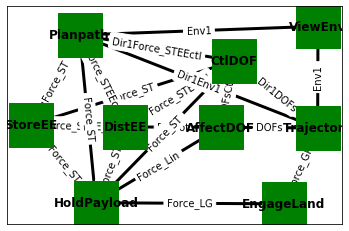

In [26]:
%matplotlib inline
rd.graph.show(mdl)

We can use the same process to arrange the bipartite graph:

In [27]:
%matplotlib qt
pos = rd.graph.set_pos(mdl, gtype='bipartite')
pos

In [28]:
pos

{'StoreEE': [-1.067135163123663, 0.32466987344741055],
 'DistEE': [-0.617149602161968, 0.3165981670924663],
 'AffectDOF': [0.11827439153655106, 0.10792528450121897],
 'CtlDOF': [-0.2636856982162134, 0.42422600969836144],
 'Planpath': [-0.9347151173753852, 0.6943421719257798],
 'Trajectory': [0.6180477286739998, 0.32930706399226856],
 'EngageLand': [0.0015917696269229786, -0.2399760932810826],
 'HoldPayload': [-0.8833099612826893, -0.247201580673997],
 'ViewEnv': [0.5725955705698363, 0.6901513410348765],
 'Force_ST': [-0.8925771348524384, -0.025638904424547027],
 'Force_Lin': [-0.5530952425102891, -0.10380834289626095],
 'Force_GR': [0.568921162299461, -0.22991830334765573],
 'Force_LG': [-0.37244114591548894, -0.2355298479531287],
 'EE_1': [-0.809433489993954, 0.319191761486317],
 'EEmot': [-0.33469985340998853, 0.1307636433702345],
 'EEctl': [-0.48751243650229525, 0.4852032717825657],
 'Ctl1': [-0.06913038312848868, 0.2445174568603189],
 'DOFs': [0.2606664304933561, 0.3243482171363975

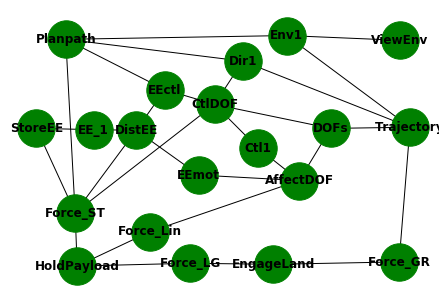

In [38]:
%matplotlib inline
rd.graph.show(mdl, gtype='bipartite', pos = bipartite_pos, scale=2)

As shown, in a large model, the Bipartite graph is often easier to arrange. Since the model will be redefined several times going forward, we will use these positions to keep a consistent layout:

In [5]:
bipartite_pos = {'StoreEE': [-1.067135163123663, 0.32466987344741055],
 'DistEE': [-0.617149602161968, 0.3165981670924663],
 'AffectDOF': [0.11827439153655106, 0.10792528450121897],
 'CtlDOF': [-0.2636856982162134, 0.42422600969836144],
 'Planpath': [-0.9347151173753852, 0.6943421719257798],
 'Trajectory': [0.6180477286739998, 0.32930706399226856],
 'EngageLand': [0.0015917696269229786, -0.2399760932810826],
 'HoldPayload': [-0.8833099612826893, -0.247201580673997],
 'ViewEnv': [0.5725955705698363, 0.6901513410348765],
 'Force_ST': [-0.8925771348524384, -0.025638904424547027],
 'Force_Lin': [-0.5530952425102891, -0.10380834289626095],
 'Force_GR': [0.568921162299461, -0.22991830334765573],
 'Force_LG': [-0.37244114591548894, -0.2355298479531287],
 'EE_1': [-0.809433489993954, 0.319191761486317],
 'EEmot': [-0.33469985340998853, 0.1307636433702345],
 'EEctl': [-0.48751243650229525, 0.4852032717825657],
 'Ctl1': [-0.06913038312848868, 0.2445174568603189],
 'DOFs': [0.2606664304933561, 0.3243482171363975],
 'Env1': [0.06157634305459603, 0.7099922980251693],
 'Dir1': [-0.13617863906968142, 0.6037252153639261]}

graph_pos = {'StoreEE': [-1.0787279392101061, -0.06903523859088145],
 'DistEE': [-0.361531174332526, -0.0935883732235363],
 'AffectDOF': [0.36541282312106205, -0.09674444529230719],
 'CtlDOF': [0.4664934329906758, 0.5822138245848214],
 'Planpath': [-0.7095750728126631, 0.8482786785038505],
 'Trajectory': [1.1006824683444765, -0.10423208715241583],
 'EngageLand': [0.8423521094741182, -0.8813666134484857],
 'HoldPayload': [-0.5857395187723944, -0.86974898769837],
 'ViewEnv': [1.1035500215472247, 0.9373523025760659]}

### Network Model

### Static Model

- graph views of faults
- static FHA/FMEA

In [4]:
class StoreEE(FxnBlock):
    def __init__(self, flows):
        self.failrate=1e-5
        self.assoc_modes({'nocharge':[1,300]})
        super().__init__(['EEout', 'FS'], flows, {'soc': 2000})
    def behavior(self, time):
        if      self.has_fault('nocharge'):   self.EEout.effort=0.0
        else: self.EEout.effort=1.0
class DistEE(FxnBlock):
    def __init__(self,flows):
        super().__init__(['EEin','EEmot','EEctl','ST'],flows, {'EEtr':1.0, 'EEte':1.0}, timely=False)
        self.failrate=1e-5
        self.assoc_modes({'short':[0.3,3000], 'degr':[0.5,1000], 'break':[0.2,2000]})
    def condfaults(self, time):
        if self.ST.support<0.5 or max(self.EEmot.rate,self.EEctl.rate)>2: 
            self.add_fault('break')
        if self.EEin.rate>2:
            self.add_fault('short')
    def behavior(self, time):
        if self.has_fault('short'): 
            self.EEte=0.0
            self.EEre=10
        elif self.has_fault('break'): 
            self.EEte=0.0
            self.EEre=0.0
        elif self.has_fault('degr'): self.EEte=0.5
        self.EEmot.effort=self.EEte*self.EEin.effort
        self.EEctl.effort=self.EEte*self.EEin.effort
        self.EEin.rate=m2to1([ self.EEin.effort, self.EEtr, max(self.EEmot.rate,self.EEctl.rate)])
class EngageLand(FxnBlock):
    def __init__(self,flows):
        super().__init__(['forcein', 'forceout'],flows, timely=False)
        self.failrate=1e-5
        self.assoc_modes({'break':[0.2, 1000], 'deform':[0.8, 1000]})
    def condfaults(self, time):
        if abs(self.forcein.value)>=2.0:      self.add_fault('break')
        elif abs(self.forcein.value)>1.5:    self.add_fault('deform')
    def behavior(self, time):
        self.forceout.value=self.forcein.value/2
            
class HoldPayload(FxnBlock):
    def __init__(self,flows):
        super().__init__(['FG', 'Lin', 'ST'],flows, timely=False)
        self.failrate=1e-6
        self.assoc_modes({'break':[0.2, 10000], 'deform':[0.8, 10000]})
    def condfaults(self, time):
        if abs(self.FG.value)>0.8:      self.add_fault('break')
        elif abs(self.FG.value)>1.0:    self.add_fault('deform')
    def behavior(self, time):
        #need to transfer FG to FA & FS???
        if self.has_fault('break'):     self.Lin.support, self.ST.support = 0,0
        elif self.has_fault('deform'):  self.Lin.support, self.ST.support = 0.5,0.5
        else:                           self.Lin.support, self.ST.support = 1.0,1.0
class AffectDOF(FxnBlock): #EEmot,Ctl1,DOFs,Force_Lin HSig_DOFs, RSig_DOFs
    def __init__(self, flows):     
        super().__init__(['EEin', 'Ctlin','DOF','Force'], flows,{'Eto': 1.0, 'Eti':1.0, 'Ct':1.0, 'Mt':1.0, 'Pt':1.0}, timely=False)
        self.failrate=1e-5
        self.assoc_modes({'short':[0.1, 200],'openc':[0.1, 200],'ctlup':[0.2, 500],'ctldn':[0.2, 500],
                          'ctlbreak':[0.2, 1000], 'mechbreak':[0.1, 500], 'mechfriction':[0.05, 500],
                          'propwarp':[0.01, 200],'propstuck':[0.02, 200], 'propbreak':[0.03, 200]})
    def behavior(self, time):
        self.Eti=1.0
        self.Eto=1.0
        if self.has_fault('short'):
            self.Eti=10
            self.Eto=0.0
        elif self.has_fault('openc'):
            self.Eti=0.0
            self.Eto=0.0
        if self.has_fault('ctlbreak'): self.Ct=0.0
        elif self.has_fault('ctldn'):  self.Ct=0.5
        elif self.has_fault('ctlup'):  self.Ct=2.0
        if self.has_fault('mechbreak'): self.Mt=0.0
        elif self.has_fault('mechfriction'):
            self.Mt=0.5
            self.Eti=2.0
        if self.has_fault('propstuck'):
            self.Pt=0.0
            self.Mt=0.0
            self.Eti=4.0
        elif self.has_fault('propbreak'): self.Pt=0.0
        elif self.has_fault('propwarp'):  self.Pt=0.5
        
        self.EEin.rate=self.Eti

        self.DOF.uppwr=self.Eto*self.Eti*self.Ctlin.upward*self.Ct*self.Mt*self.Pt
        self.DOF.planpwr=self.Eto*self.Eti*self.Ctlin.forward*self.Ct*self.Mt*self.Pt    
        
class CtlDOF(FxnBlock):
    def __init__(self, flows):
        super().__init__(['EEin','Dir','Ctl','DOFs','FS'],flows, {'Cs':1.0})
        self.failrate=1e-5
        self.assoc_modes({'noctl':[0.2, 10000], 'degctl':[0.8, 10000]})
    def condfaults(self, time):
        if self.FS.support<0.5: self.add_fault('noctl')
    def behavior(self, time):
        if self.has_fault('noctl'):    self.Cs=0.0
        elif self.has_fault('degctl'): self.Cs=0.5
        
        upthrottle=1.0
        if self.Dir.traj[2]>1:     upthrottle=2
        elif -1<self.Dir.traj[2]<1:  upthrottle= 1 + self.Dir.traj[2]
        elif self.Dir.traj[2]<=-1.0:   upthrottle = 0
            
        if self.Dir.traj[0]==0 and self.Dir.traj[1]==0: forwardthrottle=0.0
        else: forwardthrottle=1.0
        
        self.Ctl.forward=self.EEin.effort*self.Cs*forwardthrottle*self.Dir.power
        self.Ctl.upward=self.EEin.effort*self.Cs*self.Dir.power*upthrottle

class PlanPath(FxnBlock):
    def __init__(self, flows):
        super().__init__(['EEin','Env','Dir','FS'], flows)
        self.failrate=1e-5
        self.assoc_modes({'noloc':[0.2, 10000], 'degloc':[0.8, 10000]})
    def condfaults(self, time):
        if self.FS.support<0.5: self.add_fault('noloc')
    def behavior(self, t):
        self.Dir.assign([1,0,0])
        # faulty behaviors    
        if self.has_fault('noloc'):     self.Dir.assign([0,0,0])
        elif self.has_fault('degloc'):  self.Dir.assign([0,0,-1])
        if self.EEin.effort<0.5:
            self.Dir.power=0.0
            self.Dir.assign([0,0,0])

class Trajectory(FxnBlock):
    def __init__(self, flows):
        super().__init__(['Env','DOF', 'Dir', 'Force_GR'], flows)
        self.assoc_modes({'crash':[0, 100000], 'lost':[0.0, 50000]})
    def behavior(self, time):
        self.DOF.vertvel = max(min(-2+2*self.DOF.uppwr, 2), -2)
        self.Force_GR.value =self.DOF.vertvel
        self.DOF.planvel=self.DOF.planpwr
        if self.DOF.vertvel>1.5 or self.DOF.vertvel<-1:
            self.add_fault('crash')
            self.Env.elev=0.0
        if self.DOF.planvel>1.5 or self.DOF.planvel<0.5:
            self.add_fault('lost')
            self.x=0.0
        else:
            self.x=1.0

class ViewEnvironment(FxnBlock):
    def __init__(self, flows):
        super().__init__(['Env'], flows)
        self.failrate=1e-5
        self.assoc_modes({'poorview':[0.2, 10000]})

class Direc(Flow):
    def __init__(self):
        self.traj=[0,0,0]
        super().__init__({'x': self.traj[0], 'y': self.traj[1], 'z': self.traj[2], 'power': 1}, 'Trajectory')
    def assign(self, traj):
        self.x=traj[0]
        self.y=traj[1]
        self.z=traj[2]
        self.traj=traj
    def status(self):
        status={'x': self.traj[0], 'y': self.traj[1], 'z': self.traj[2], 'power': self.power}
        return status.copy()
        
class Drone(Model):
    def __init__(self, params={'graph_pos':{}, 'bipartite_pos':{}}):
        super().__init__()
        self.params=params
        #add flows to the model
        self.add_flow('Force_ST', {'support':1.0})
        self.add_flow('Force_Lin', {'support':1.0})
        self.add_flow('Force_GR' , {'value':0.0})
        self.add_flow('Force_LG', {'value':0.0})
        self.add_flow('EE_1', {'rate':1.0, 'effort':1.0})
        self.add_flow('EEmot', {'rate':1.0, 'effort':1.0})
        self.add_flow('EEctl', {'rate':1.0, 'effort':1.0})
        self.add_flow('Ctl1', {'forward':1.0, 'upward':1.0})
        self.add_flow('DOFs', {'vertvel':1.0, 'planvel':1.0, 'planpwr':1.0, 'uppwr':1.0})
        self.add_flow('Env1', {'x':0.0,'y':0.0,'elev':50} )
        # custom flows
        self.add_flow('Dir1', Direc())
        #add functions to the model
        flows=['EEctl', 'Force_ST']
        self.add_fxn('StoreEE',['EE_1', 'Force_ST'], fclass=StoreEE)
        self.add_fxn('DistEE', ['EE_1','EEmot','EEctl', 'Force_ST'], fclass=DistEE)
        self.add_fxn('AffectDOF',['EEmot','Ctl1','DOFs','Force_Lin'], fclass=AffectDOF)
        self.add_fxn('CtlDOF', ['EEctl', 'Dir1', 'Ctl1', 'DOFs', 'Force_ST'], fclass=CtlDOF)
        self.add_fxn('Planpath', ['EEctl', 'Env1','Dir1', 'Force_ST'], fclass=PlanPath)
        self.add_fxn('Trajectory', ['Env1','DOFs','Dir1', 'Force_GR'], fclass=Trajectory)
        self.add_fxn('EngageLand',['Force_GR', 'Force_LG'], fclass=EngageLand)
        self.add_fxn('HoldPayload',['Force_LG', 'Force_Lin', 'Force_ST'], fclass=HoldPayload)
        self.add_fxn('ViewEnv', ['Env1'], fclass=ViewEnvironment)
        
        self.construct_graph(graph_pos=params['graph_pos'], bipartite_pos=params['bipartite_pos'])
    def find_classification(self, g, endfaults, endflows, scen, mdlhist):
    
        repcost=sum([ c['rcost'] for f,m in endfaults.items() for a, c in m.items()])
        
        totcost=repcost
        rate=scen['properties']['rate']
        expcost=totcost*rate*1e5
        return {'rate':rate, 'cost': totcost, 'expected cost': expcost}

In [5]:
static_mdl = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})

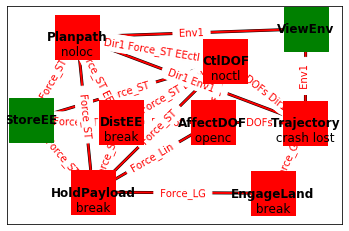

In [6]:
endresults, resgraph, mdlhist = fs.propagate.one_fault(static_mdl,'AffectDOF', 'openc')
rd.graph.show(resgraph, pos = graph_pos, scale=2)

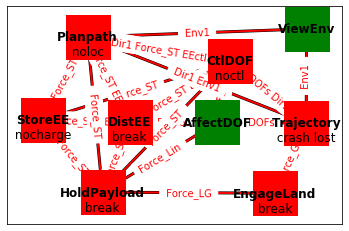

In [7]:
endresults, resgraph, mdlhist = fs.propagate.one_fault(static_mdl,'StoreEE', 'nocharge')
rd.graph.show(resgraph, pos = graph_pos, scale=2)

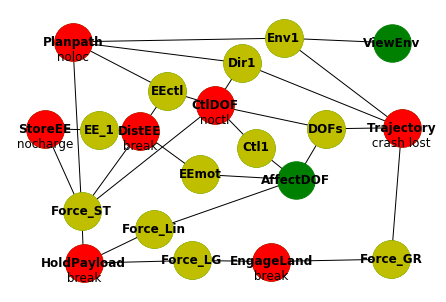

In [8]:
endresults, resgraph, mdlhist = fs.propagate.one_fault(static_mdl,'StoreEE', 'nocharge', gtype='bipartite')
rd.graph.show(resgraph, pos = bipartite_pos, scale=2, gtype='bipartite')

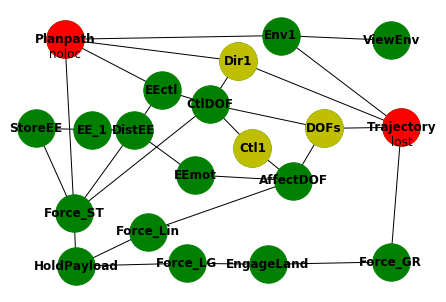

In [11]:
endresults, resgraph, mdlhist = fs.propagate.one_fault(static_mdl,'Planpath', 'noloc', gtype='bipartite')
rd.graph.show(resgraph, pos = bipartite_pos, scale=2, gtype='bipartite')

In [10]:
endclasses, mdlhists = fs.propagate.single_faults(static_mdl)

In [14]:
reshists, diffs, summaries = rd.process.hists(mdlhists)
static_fmea = rd.tabulate.fullfmea(endclasses, summaries)
static_fmea.sort_values('expected cost', ascending=False)

,degraded functions,degraded flows,rate,cost,expected cost
"StoreEE nocharge, t=1","[StoreEE, DistEE, CtlDOF, Planpath, Trajectory...","[Force_ST, Force_Lin, Force_GR, Force_LG, EE_1...",1e-05,183300,183300
"Planpath degloc, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",8e-06,193000,154400
"DistEE short, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",3e-06,186000,55800
"AffectDOF ctlbreak, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",2e-06,184000,36800
"AffectDOF ctlup, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",2e-06,183500,36700
"DistEE break, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",2e-06,183000,36600
"CtlDOF noctl, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",2e-06,183000,36600
"AffectDOF short, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EE_1...",1e-06,186200,18620
"AffectDOF mechbreak, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",1e-06,183500,18350
"AffectDOF openc, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",1e-06,183200,18320


### Dynamic Model

- Behavior-over-time graph

- Dynamic/phase based FMEA

In [88]:
class StoreEE(FxnBlock):
    def __init__(self, flows):
        self.failrate=1e-5
        self.assoc_modes({'nocharge':[1,300]})
        super().__init__(['EEout', 'FS'], flows, {'soc': 250})
    def condfaults(self,time):
        if self.soc<1:
            self.soc=0
            self.has_fault('nocharge')
    def behavior(self, time):
        if      self.has_fault('nocharge'):   self.EEout.effort=0.0
        else: self.EEout.effort=1.0
        if time > self.time:
            self.soc=self.soc-self.EEout.effort*self.EEout.rate*(time-self.time)
class DistEE(FxnBlock):
    def __init__(self,flows):
        super().__init__(['EEin','EEmot','EEctl','ST'],flows, {'EEtr':1.0, 'EEte':1.0}, timely=False)
        self.failrate=1e-5
        self.assoc_modes({'short':[0.3,3000], 'degr':[0.5,1000], 'break':[0.2,2000]})
    def condfaults(self, time):
        if self.ST.support<0.5 or max(self.EEmot.rate,self.EEctl.rate)>2: 
            self.add_fault('break')
        if self.EEin.rate>2:
            self.add_fault('short')
    def behavior(self, time):
        if self.has_fault('short'): 
            self.EEte=0.0
            self.EEre=10
        elif self.has_fault('break'): 
            self.EEte=0.0
            self.EEre=0.0
        elif self.has_fault('degr'): self.EEte=0.5
        self.EEmot.effort=self.EEte*self.EEin.effort
        self.EEctl.effort=self.EEte*self.EEin.effort
        self.EEin.rate=m2to1([ self.EEin.effort, self.EEtr, 0.9*self.EEmot.rate+0.1*self.EEctl.rate])
class EngageLand(FxnBlock):
    def __init__(self,flows):
        super().__init__(['forcein', 'forceout'],flows, timely=False)
        self.failrate=1e-5
        self.assoc_modes({'break':[0.2, 1000], 'deform':[0.8, 1000]})
    def condfaults(self, time):
        if abs(self.forcein.value)>=2.0:      self.add_fault('break')
        elif abs(self.forcein.value)>1.5:    self.add_fault('deform')
    def behavior(self, time):
        self.forceout.value=self.forcein.value/2
            
class HoldPayload(FxnBlock):
    def __init__(self,flows):
        super().__init__(['FG', 'Lin', 'ST'],flows, timely=False)
        self.failrate=1e-6
        self.assoc_modes({'break':[0.2, 10000], 'deform':[0.8, 10000]})
    def condfaults(self, time):
        if abs(self.FG.value)>0.8:      self.add_fault('break')
        elif abs(self.FG.value)>1.0:    self.add_fault('deform')
    def behavior(self, time):
        #need to transfer FG to FA & FS???
        if self.has_fault('break'):     self.Lin.support, self.ST.support = 0,0
        elif self.has_fault('deform'):  self.Lin.support, self.ST.support = 0.5,0.5
        else:                           self.Lin.support, self.ST.support = 1.0,1.0
class AffectDOF(FxnBlock): #EEmot,Ctl1,DOFs,Force_Lin HSig_DOFs, RSig_DOFs
    def __init__(self, flows):     
        super().__init__(['EEin', 'Ctlin','DOF','Force'], flows,{'Eto': 1.0, 'Eti':1.0, 'Ct':1.0, 'Mt':1.0, 'Pt':1.0}, timely=False)
        self.failrate=1e-5
        self.assoc_modes({'short':[0.1, 200],'openc':[0.1, 200],'ctlup':[0.2, 500],'ctldn':[0.2, 500],
                          'ctlbreak':[0.2, 1000], 'mechbreak':[0.1, 500], 'mechfriction':[0.05, 500],
                          'propwarp':[0.01, 200],'propstuck':[0.02, 200], 'propbreak':[0.03, 200]})
    def behavior(self, time):
        self.Eti=1.0
        self.Eto=1.0
        if self.has_fault('short'):
            self.Eti=10
            self.Eto=0.0
        elif self.has_fault('openc'):
            self.Eti=0.0
            self.Eto=0.0
        elif self.Ctlin.upward==0 and self.Ctlin.forward == 0:
            self.Eti = 0.0
        if self.has_fault('ctlbreak'): self.Ct=0.0
        elif self.has_fault('ctldn'):  self.Ct=0.5
        elif self.has_fault('ctlup'):  self.Ct=2.0
        if self.has_fault('mechbreak'): self.Mt=0.0
        elif self.has_fault('mechfriction'):
            self.Mt=0.5
            self.Eti=2.0
        if self.has_fault('propstuck'):
            self.Pt=0.0
            self.Mt=0.0
            self.Eti=4.0
        elif self.has_fault('propbreak'): self.Pt=0.0
        elif self.has_fault('propwarp'):  self.Pt=0.5
        
        self.EEin.rate=self.Eti

        self.DOF.uppwr=self.Eto*self.Eti*self.Ctlin.upward*self.Ct*self.Mt*self.Pt
        self.DOF.planpwr=self.Eto*self.Eti*self.Ctlin.forward*self.Ct*self.Mt*self.Pt    
        
class CtlDOF(FxnBlock):
    def __init__(self, flows):
        super().__init__(['EEin','Dir','Ctl','DOFs','FS'],flows, {'vel':0.0, 'Cs':1.0})
        self.failrate=1e-5
        self.assoc_modes({'noctl':[0.2, 10000], 'degctl':[0.8, 10000]})
    def condfaults(self, time):
        if self.FS.support<0.5: self.add_fault('noctl')
    def behavior(self, time):
        if self.has_fault('noctl'):    self.Cs=0.0
        elif self.has_fault('degctl'): self.Cs=0.5
        
        upthrottle=1.0
        if self.Dir.traj[2]>1:     upthrottle=2.0
        elif 0<self.Dir.traj[2]<=1:  upthrottle= self.Dir.traj[2] + 1.0
        elif self.Dir.traj[2]==0:
            damp=np.sign(self.vel)
            damp2=damp*min(1.0, np.power(self.vel, 2))
            upthrottle=1.0-0.2*damp2
        elif -1<self.Dir.traj[2]<=0.0:
            damp=min(1.0, np.power(self.vel+0.5, 2))
            upthrottle=0.75+0.25*damp
        elif self.Dir.traj[2]<=-1.0:
            damp=min(0.75, np.power(self.vel+5.0, 2))
            upthrottle=0.75+0.15*damp
            
        if self.Dir.traj[0]==0 and self.Dir.traj[1]==0: forwardthrottle=0.0
        else: forwardthrottle=1.0
        
        self.Ctl.forward=self.EEin.effort*self.Cs*forwardthrottle*self.Dir.power
        self.Ctl.upward=self.EEin.effort*self.Cs*self.Dir.power*upthrottle

class PlanPath(FxnBlock):
    def __init__(self, flows):
        super().__init__(['EEin','Env','Dir','FS'], flows, states={'dx':0.0, 'dy':0.0, 'dz':0.0, 'pt':1, 'mode':'taxi'},timers={'pause'})
        
        self.goals = {1:[0,0,50], 2:[100, 0, 50], 3:[100, 100, 50], 4:[150, 150, 50], 5:[0,0,50], 6:[0,0,0]}
        self.queue = list(self.goals.keys())
        self.queue.reverse()
        self.goal = self.goals[1]
        self.failrate=1e-5
        self.assoc_modes({'noloc':[0.2, 10000], 'degloc':[0.8, 10000]})
    def condfaults(self, time):
        if self.FS.support<0.5: self.add_fault('noloc')
    def behavior(self, t):
        loc = [self.Env.x, self.Env.y, self.Env.elev]
        dist = finddist(loc, self.goal)        
        [self.dx,self.dy, self.dz] = vectdist(self.goal,loc)
        
        if self.mode=='taxi' and t>5: self.mode=='taxi'
        elif dist<5 and {'move', 'hover'}.issuperset({self.mode}):
            self.mode='hover'
            if t>self.time:
                self.pause.inc(1)
                if self.pause.t() > 2:
                    self.pt=self.queue.pop()
                    self.goal = self.goals[self.pt]
                    self.pause.reset()
        elif self.Env.elev<1 and len(self.queue)==0: self.mode = 'taxi'
        elif dist<5 and len(self.queue)==0:         self.mode = 'land'
        elif len(self.queue)==0 and {'move', 'hover'}.issuperset({self.mode}): self.mode = 'descend'
        elif dist>5 and not(self.mode=='descend'):                       self.mode='move'
        # nominal behaviors
        self.Dir.power=1.0
        if self.mode=='taxi':       self.Dir.power=0.0
        elif self.mode=='hover':    self.Dir.assign([0,0,0])           
        elif self.mode=='move':     self.Dir.assign(vectdir(self.goal, loc))     
        elif self.mode=='descend':  self.Dir.assign([0,0,-0.5])
        elif self.mode=='land':     self.Dir.assign([0,0,-0.1])
        # faulty behaviors    
        if self.has_fault('noloc'):     self.Dir.assign([0,0,0])
        elif self.has_fault('degloc'):  self.Dir.assign([0,0,-1])
        if self.EEin.effort<0.5:
            self.Dir.power=0.0
            self.Dir.assign([0,0,0])

class Trajectory(FxnBlock):
    def __init__(self, flows):
        super().__init__(['Env','DOF', 'Dir', 'Force_GR'], flows)
        #self.assoc_modes({'crash':[0, 100000], 'lost':[0.0, 50000]})
    def behavior(self, time):
        if time>self.time:            
            if self.Env.elev<=0.0:  
                self.Force_GR.value=min(-0.5, (self.DOF.vertvel-self.DOF.planvel)/7.5)
                acc=10*self.DOF.uppwr
            else:                   
                self.Force_GR.value=0.0
                acc=10*(self.DOF.uppwr-1.0) 
            
            sign=np.sign(self.DOF.vertvel)
            damp=(-0.02*sign*np.power(self.DOF.vertvel, 2)-0.1*self.DOF.vertvel)
            self.DOF.vertvel=self.DOF.vertvel+(acc+damp)
            self.DOF.planvel=10.0*self.DOF.planpwr            
            if self.Env.elev<=0.0:  
                self.DOF.vertvel=max(0,self.DOF.vertvel)
                self.DOF.planvel=0.0
            
            self.Env.elev=max(0.0, self.Env.elev+self.DOF.vertvel)
            self.Env.x=self.Env.x+self.DOF.planvel*self.Dir.traj[0]
            self.Env.y=self.Env.y+self.DOF.planvel*self.Dir.traj[1]

class ViewEnvironment(FxnBlock):
    def __init__(self, flows):
        super().__init__(['Env'], flows)
        sq=square([0,150], 160, 160)
        self.viewingarea = {(x,y):'unviewed' for x in range(int(sq[0][0]),int(sq[1][0])+10,10) for y in range(int(sq[0][1]),int(sq[2][1])+10,10)}
    def behavior(self, time):
        area = square((self.Env.x, self.Env.y), 10, 10)
        for spot in self.viewingarea:
            if inrange(area, spot[0],spot[1]): self.viewingarea[spot]='viewed'

class Direc(Flow):
    def __init__(self):
        self.traj=[0,0,0]
        super().__init__({'x': self.traj[0], 'y': self.traj[1], 'z': self.traj[2], 'power': 1}, 'Trajectory')
    def assign(self, traj):
        self.x=traj[0]
        self.y=traj[1]
        self.z=traj[2]
        self.traj=traj
    def status(self):
        status={'x': self.traj[0], 'y': self.traj[1], 'z': self.traj[2], 'power': self.power}
        return status.copy()
        
class Drone(Model):
    def __init__(self, params={'graph_pos':{}, 'bipartite_pos':{}}):
        super().__init__(modelparams={'phases': {'ascend':[0,5],'forward':[5,95], 'descend':[95, 100]},
                                     'times':[0,135], 'units':'sec'})
        self.params=params
        #add flows to the model
        self.add_flow('Force_ST', {'support':1.0})
        self.add_flow('Force_Lin', {'support':1.0})
        self.add_flow('Force_GR' , {'value':0.0})
        self.add_flow('Force_LG', {'value':0.0})
        self.add_flow('EE_1', {'rate':1.0, 'effort':1.0})
        self.add_flow('EEmot', {'rate':1.0, 'effort':1.0})
        self.add_flow('EEctl', {'rate':1.0, 'effort':1.0})
        self.add_flow('Ctl1', {'forward':0.0, 'upward':1.0})
        self.add_flow('DOFs', {'vertvel':0.0, 'planvel':0.0, 'planpwr':0.0, 'uppwr':0.0})
        self.add_flow('Env1', {'x':0.0,'y':0.0,'elev':0.0} )
        # custom flows
        self.add_flow('Dir1', Direc())
        #add functions to the model
        flows=['EEctl', 'Force_ST']
        self.add_fxn('StoreEE',['EE_1', 'Force_ST'], fclass=StoreEE)
        self.add_fxn('DistEE', ['EE_1','EEmot','EEctl', 'Force_ST'], fclass=DistEE)
        self.add_fxn('AffectDOF',['EEmot','Ctl1','DOFs','Force_Lin'], fclass=AffectDOF)
        self.add_fxn('CtlDOF', ['EEctl', 'Dir1', 'Ctl1', 'DOFs', 'Force_ST'], fclass=CtlDOF)
        self.add_fxn('Planpath', ['EEctl', 'Env1','Dir1', 'Force_ST'], fclass=PlanPath)
        self.add_fxn('Trajectory', ['Env1','DOFs','Dir1', 'Force_GR'], fclass=Trajectory)
        self.add_fxn('EngageLand',['Force_GR', 'Force_LG'], fclass=EngageLand)
        self.add_fxn('HoldPayload',['Force_LG', 'Force_Lin', 'Force_ST'], fclass=HoldPayload)
        self.add_fxn('ViewEnv', ['Env1'], fclass=ViewEnvironment)
        
        self.construct_graph(graph_pos=params['graph_pos'], bipartite_pos=params['bipartite_pos'])
    def find_classification(self, g, endfaults, endflows, scen, mdlhist):
        if -5 >mdlhist['faulty']['flows']['Env1']['x'][-1] or 5<mdlhist['faulty']['flows']['Env1']['x'][-1]:
            lostcost=50000
        elif -5 >mdlhist['faulty']['flows']['Env1']['y'][-1] or 5<mdlhist['faulty']['flows']['Env1']['y'][-1]:
            lostcost=50000
        elif mdlhist['faulty']['flows']['Env1']['elev'][-1] >5:
            lostcost=50000
        else:
            lostcost=0
        
        if any(mdlhist['faulty']['flows']['Force_GR']['value']>1):
            crashcost = 100000
        else:
            crashcost = 0
        
        repcost=sum([ c['rcost'] for f,m in endfaults.items() for a, c in m.items()])
        
        totcost=repcost + crashcost + lostcost
        rate=scen['properties']['rate']
        expcost=totcost*rate*1e5
        return {'rate':rate, 'cost': totcost, 'expected cost': expcost}
def square(center,xw,yw):
    square=[[center[0]-xw/2,center[1]-yw/2],\
            [center[0]+xw/2,center[1]-yw/2], \
            [center[0]+xw/2,center[1]+yw/2],\
            [center[0]-xw/2,center[1]+yw/2]]
    return square
#checks to see if a point with x-y coordinates is in the area a
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
def inrange(area, x, y):
    point=Point(x,y)
    polygon=Polygon(area)
    return polygon.contains(point)

def finddist(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2)

def calcdist(p1, p2):
    return np.sqrt((p1[0]-p2.x)**2+(p1[1]-p2.y)**2+(p1[2]-p2.elev)**2)

def vectdist(p1, p2):
    return [p1[0]-p2[0],p1[1]-p2[1],p1[2]-p2[2]]

def vectdir(p1, p2):
    return vectdist(p1,p2)/finddist(p1,p2)

In [89]:
# Note: because of the complicated functions, the model must be re-instantiated for each function in order to work in this case
dynamic_mdl = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})

In [90]:
endresults, resgraph, mdlhist = fs.propagate.nominal(dynamic_mdl)

In [91]:
endresults

{'faults': {},
 'classification': {'rate': 1.0, 'cost': 0, 'expected cost': 0.0}}

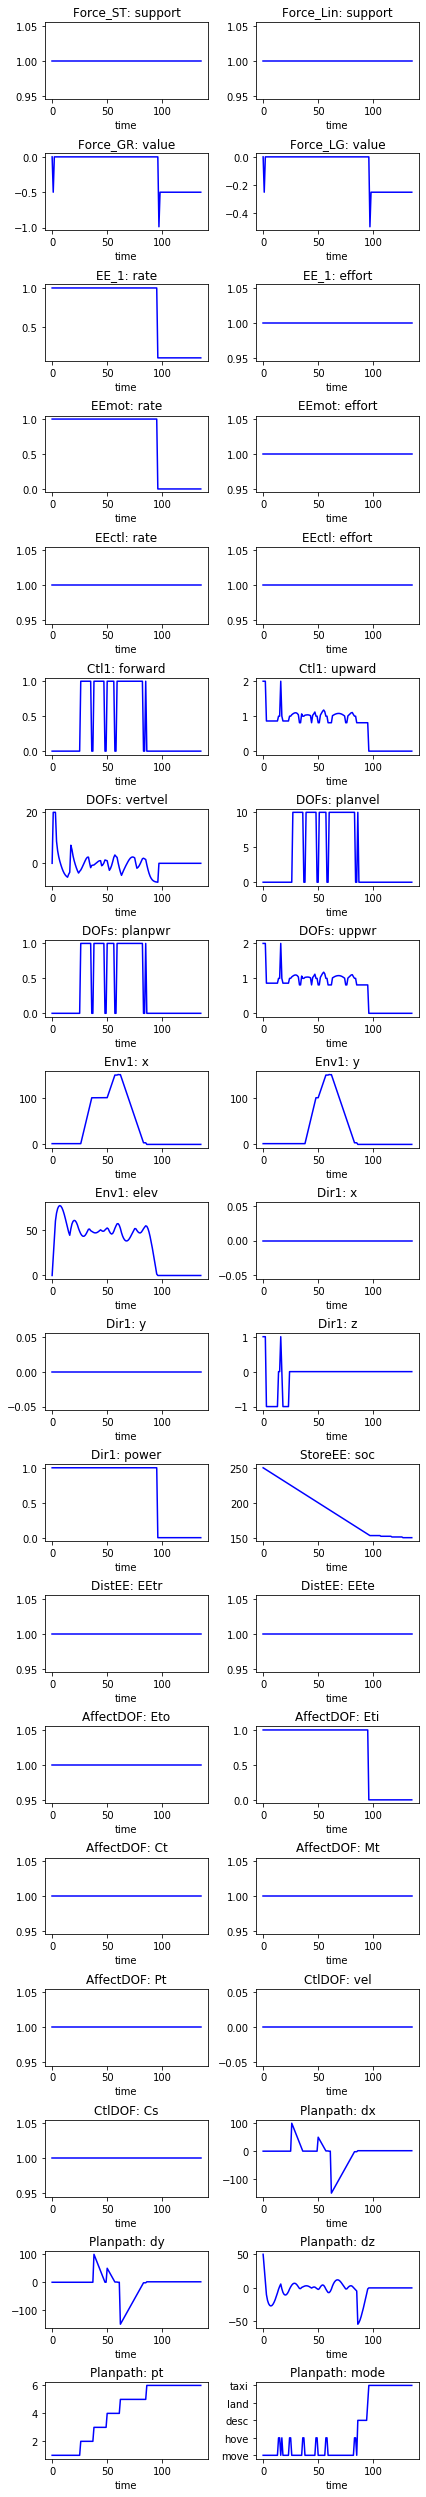

In [92]:
rd.plot.mdlhistvals(mdlhist)

In [93]:
rd.tabulate.hist(mdlhist)[:15]

time StoreEE             DistEE                  AffectDOF       ...  \
       t  faults  soc faults faults EEtr EEte faults    faults  Eto  ...   
0    0.0   {nom}  250  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
1    1.0   {nom}  249  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
2    2.0   {nom}  248  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
3    3.0   {nom}  247  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
4    4.0   {nom}  246  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
5    5.0   {nom}  245  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
6    6.0   {nom}  244  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
7    7.0   {nom}  243  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
8    8.0   {nom}  242  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
9    9.0   {nom}  241  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
10  10.0   {nom}  240  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
11  11.0   {nom}  239  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
12  12.0   {nom}  238  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
13  13.0   {nom}  237  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   
14  14.0   {nom}  236  {nom}  {nom}  1.0  1.0  {nom}     {nom}  1.0  ...   

      DOFs                 Env1                 Dir1              
   planvel planpwr   uppwr    x    y       elev    x  y  z power  
0      0.0     0.0  2.0000  0.0  0.0   0.000000    0  0  1     1  
1      0.0     0.0  2.0000  0.0  0.0  20.000000    0  0  1     1  
2      0.0     0.0  2.0000  0.0  0.0  40.000000    0  0  1     1  
3      0.0     0.0  0.8625  0.0  0.0  60.000000    0  0 -1     1  
4      0.0     0.0  0.8625  0.0  0.0  68.625000    0  0 -1     1  
5      0.0     0.0  0.8625  0.0  0.0  73.524687    0  0 -1     1  
6      0.0     0.0  0.8625  0.0  0.0  76.079267    0  0 -1     1  
7      0.0     0.0  0.8625  0.0  0.0  76.872872    0  0 -1     1  
8      0.0     0.0  0.8625  0.0  0.0  76.199520    0  0 -1     1  
9      0.0     0.0  0.8625  0.0  0.0  74.227571    0  0 -1     1  
10     0.0     0.0  0.8625  0.0  0.0  71.155588    0  0 -1     1  
11     0.0     0.0  0.8625  0.0  0.0  67.204546    0  0 -1     1  
12     0.0     0.0  0.8625  0.0  0.0  62.585822    0  0 -1     1  
13     0.0     0.0  0.8625  0.0  0.0  57.480623    0  0 -1     1  
14     0.0     0.0  1.0000  0.0  0.0  52.032205    0  0  0     1  

[15 rows x 57 columns]

In [95]:
dynamic_mdl = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
endresults, resgraph, mdlhist = fs.propagate.one_fault(dynamic_mdl,'Planpath', 'noloc', time=50)

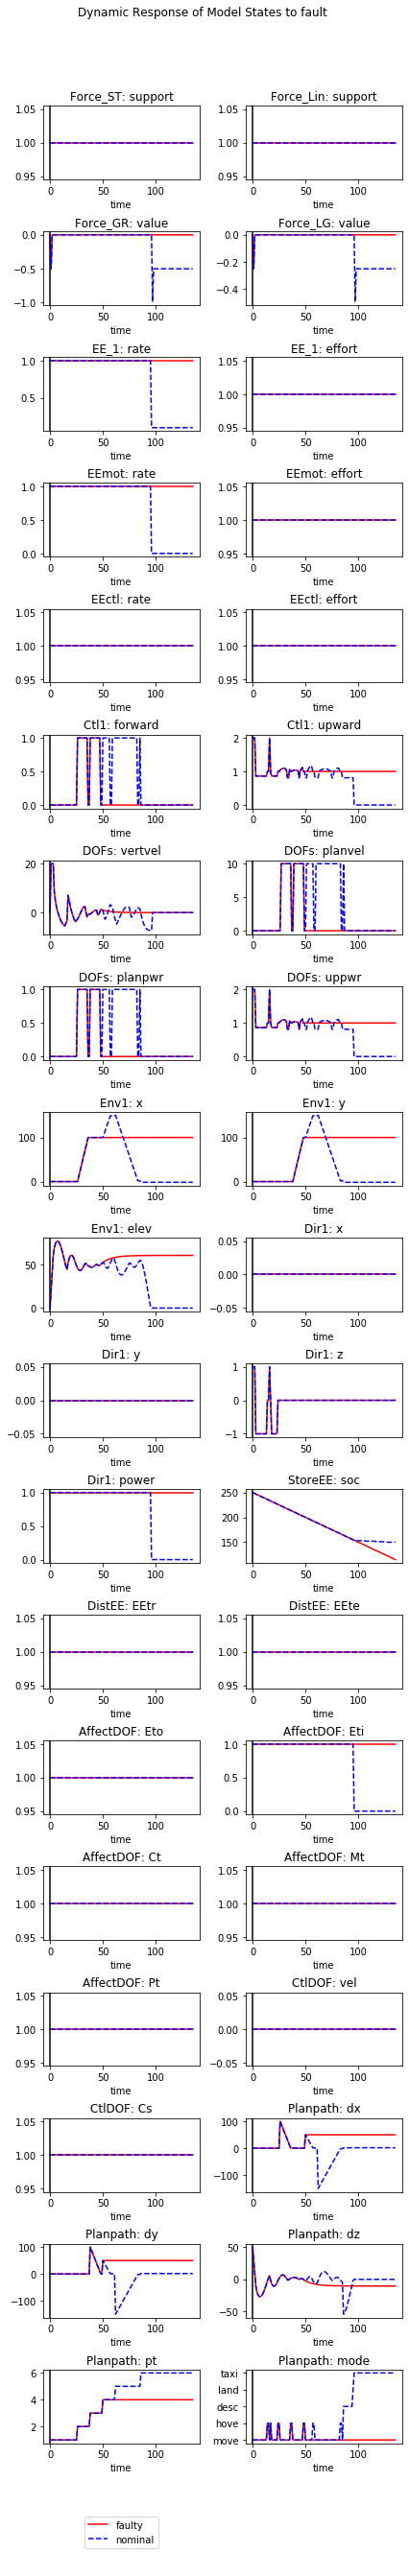

In [96]:
rd.plot.mdlhistvals(mdlhist)

In [97]:
dynamic_mdl = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
endresults, resgraph, mdlhist = fs.propagate.one_fault(dynamic_mdl,'StoreEE', 'nocharge', time=50)

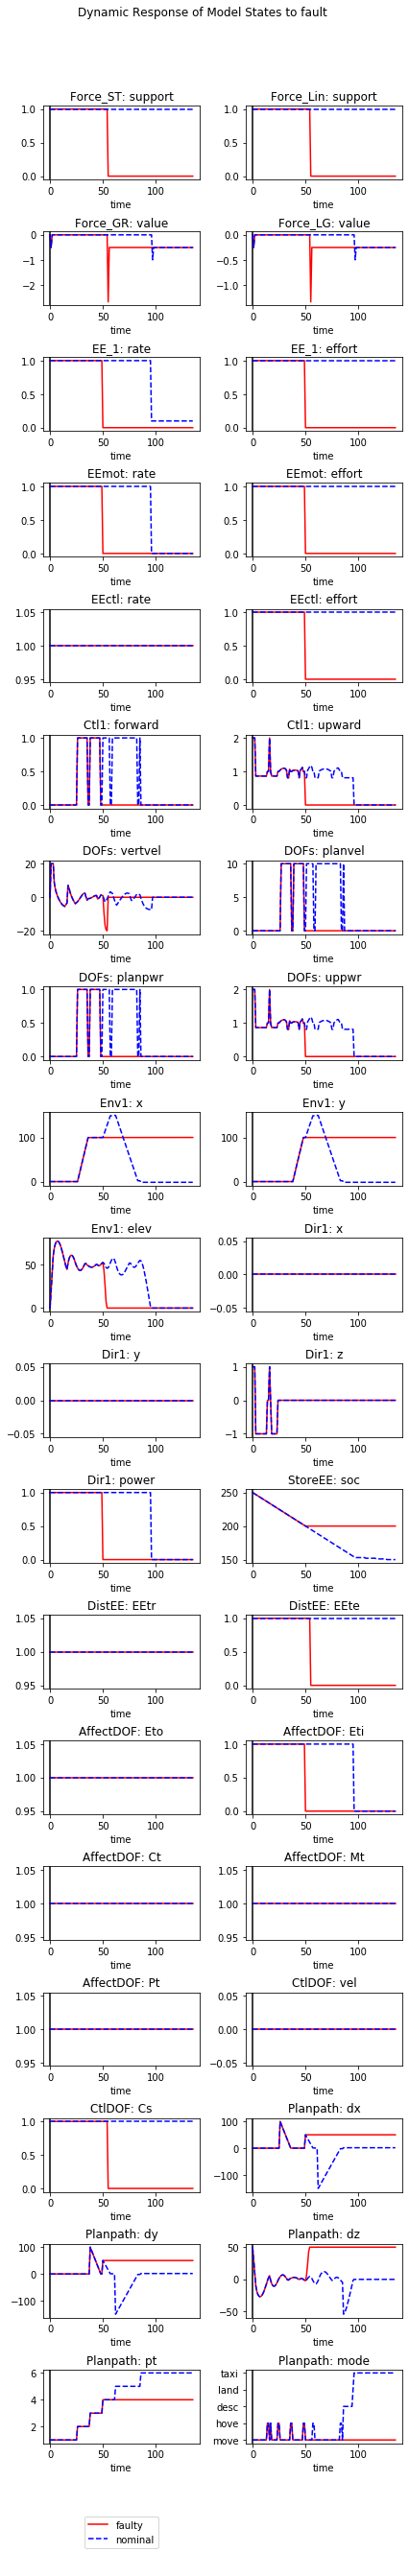

In [98]:
rd.plot.mdlhistvals(mdlhist)

In [99]:
dynamic_mdl = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
endresults, resgraph, mdlhist = fs.propagate.one_fault(dynamic_mdl,'AffectDOF', 'mechbreak', time=100)

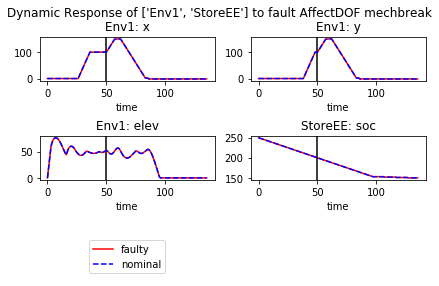

In [100]:
rd.plot.mdlhistvals(mdlhist,'AffectDOF mechbreak', time=50, fxnflowvals={'Env1':['x','y','elev'], 'StoreEE':['soc']})

### Hierarchical Model

- Same as Dynamic?
- Comparison of System Architectures

In [101]:
class StoreEE(FxnBlock):
    def __init__(self, flows):
        self.failrate=1e-5
        self.assoc_modes({'nocharge':[1,[0.6,0.1,0.1],300]})
        super().__init__(['EEout', 'FS'], flows, {'soc': 250})
    def condfaults(self,time):
        if self.soc<1:
            self.soc=0
            self.has_fault('nocharge')
    def behavior(self, time):
        if      self.has_fault('nocharge'):   self.EEout.effort=0.0
        else: self.EEout.effort=1.0
        if time > self.time:
            self.soc=self.soc-self.EEout.effort*self.EEout.rate*(time-self.time)
class DistEE(FxnBlock):
    def __init__(self,flows):
        super().__init__(['EEin','EEmot','EEctl','ST'],flows, {'EEtr':1.0, 'EEte':1.0}, timely=False)
        self.failrate=1e-5
        self.assoc_modes({'short':[0.3,[0.33, 0.33, 0.33],3000], 'degr':[0.5,[0.33, 0.33, 0.33],1000],\
                          'break':[0.2,[0.33, 0.33, 0.33],2000]})
    def condfaults(self, time):
        if self.ST.support<0.5 or max(self.EEmot.rate,self.EEctl.rate)>2: 
            self.add_fault('break')
        if self.EEin.rate>2:
            self.add_fault('short')
    def behavior(self, time):
        if self.has_fault('short'): 
            self.EEte=0.0
            self.EEre=10
        elif self.has_fault('break'): 
            self.EEte=0.0
            self.EEre=0.0
        elif self.has_fault('degr'): self.EEte=0.5
        self.EEmot.effort=self.EEte*self.EEin.effort
        self.EEctl.effort=self.EEte*self.EEin.effort
        self.EEin.rate=m2to1([ self.EEin.effort, self.EEtr, 0.9*self.EEmot.rate+0.1*self.EEctl.rate])
class EngageLand(FxnBlock):
    def __init__(self,flows):
        super().__init__(['forcein', 'forceout'],flows, timely=False)
        self.failrate=1e-5
        self.assoc_modes({'break':[0.2,[0.5,0.0,0.5], 1000], 'deform':[0.8,[0.5,0.0,0.5], 1000]})
    def condfaults(self, time):
        if abs(self.forcein.value)>=2.0:      self.add_fault('break')
        elif abs(self.forcein.value)>1.5:    self.add_fault('deform')
    def behavior(self, time):
        self.forceout.value=self.forcein.value/2
            
class HoldPayload(FxnBlock):
    def __init__(self,flows):
        super().__init__(['FG', 'Lin', 'ST'],flows, timely=False)
        self.failrate=1e-6
        self.assoc_modes({'break':[0.2, [0.33, 0.33, 0.33], 10000], 'deform':[0.8, [0.33, 0.33, 0.33], 10000]})
    def condfaults(self, time):
        if abs(self.FG.value)>0.8:      self.add_fault('break')
        elif abs(self.FG.value)>1.0:    self.add_fault('deform')
    def behavior(self, time):
        #need to transfer FG to FA & FS???
        if self.has_fault('break'):     self.Lin.support, self.ST.support = 0,0
        elif self.has_fault('deform'):  self.Lin.support, self.ST.support = 0.5,0.5
        else:                           self.Lin.support, self.ST.support = 1.0,1.0
class AffectDOF(FxnBlock): #EEmot,Ctl1,DOFs,Force_Lin HSig_DOFs, RSig_DOFs
    def __init__(self, flows, archtype):     
        self.archtype=archtype
        if archtype=='quad':
            components={'RF':Line('RF'), 'LF':Line('LF'), 'LR':Line('LR'), 'RR':Line('RR')}
            self.upward={'RF':1,'LF':1,'LR':1,'RR':1}
            self.forward={'RF':0.5,'LF':0.5,'LR':-0.5,'RR':-0.5}
            self.LR = {'L':{'LF', 'LR'}, 'R':{'RF','RR'}}
            self.FR = {'F':{'LF', 'RF'}, 'R':{'LR', 'RR'}}
        elif archtype=='oct':
            components={'RF':Line('RF'), 'LF':Line('LF'), 'LR':Line('LR'), 'RR':Line('RR'),'RF2':Line('RF2'), 'LF2':Line('LF2'), 'LR2':Line('LR2'), 'RR2':Line('RR2')}
            self.upward={'RF':1,'LF':1,'LR':1,'RR':1,'RF2':1,'LF2':1,'LR2':1,'RR2':1}
            self.forward={'RF':0.5,'LF':0.5,'LR':-0.5,'RR':-0.5,'RF2':0.5,'LF2':0.5,'LR2':-0.5,'RR2':-0.5}
            self.LR = {'L':{'LF', 'LR','LF2', 'LR2'}, 'R':{'RF','RR','RF2','RR2'}}
            self.FR = {'F':{'LF', 'RF','LF2', 'RF2'}, 'R':{'LR', 'RR','LR2', 'RR2'}}
        super().__init__(['EEin', 'Ctlin','DOF','Force'], flows,{'LRstab':0.0, 'FRstab':0.0}, components, timely=False) 
    def behavior(self, time):
        Air,EEin={},{}
        #injects faults into lines
        for linname,lin in self.components.items():
            cmds={'up':self.upward[linname], 'for':self.forward[linname]}
            lin.behavior(self.EEin.effort, self.Ctlin, cmds, self.Force.support) 
            Air[lin.name]=lin.Airout
            EEin[lin.name]=lin.EE_in
        
        if any(value>=10 for value in EEin.values()): self.EEin.rate=10
        elif any(value!=0.0 for value in EEin.values()): self.EEin.rate=sum(EEin.values())/len(EEin) #should it really be max?
        else: self.EEin.rate=0.0
        
        self.LRstab = (sum([Air[comp] for comp in self.LR['L']])-sum([Air[comp] for comp in self.LR['R']]))/len(Air)
        self.FRstab = (sum([Air[comp] for comp in self.FR['R']])-sum([Air[comp] for comp in self.FR['F']]))/len(Air)
        
        if abs(self.LRstab) >=0.4 or abs(self.FRstab)>=0.65:
            self.DOF.uppwr=0
            self.DOF.planpwr=0
        else:
            Airs=list(Air.values())
            self.DOF.uppwr=np.mean(Airs)
            self.DOF.planpwr=-2*self.FRstab

class Line(Component):
    def __init__(self, name):
        super().__init__(name,{'Eto': 1.0, 'Eti':1.0, 'Ct':1.0, 'Mt':1.0, 'Pt':1.0}, timely=False)
        self.failrate=1e-5
        self.assoc_modes({'short':[0.1, [0.33, 0.33, 0.33], 200],'openc':[0.1, [0.33, 0.33, 0.33], 200],\
                          'ctlup':[0.2, [0.33, 0.33, 0.33], 500],'ctldn':[0.2, [0.33, 0.33, 0.33], 500],\
                          'ctlbreak':[0.2, [0.33, 0.33, 0.33], 1000], 'mechbreak':[0.1, [0.33, 0.33, 0.33], 500],\
                          'mechfriction':[0.05, [0.0, 0.5,0.5], 500],'propwarp':[0.01, [0.0, 0.5,0.5], 200],\
                          'propstuck':[0.02, [0.0, 0.5,0.5], 200], 'propbreak':[0.03, [0.0, 0.5,0.5], 200]},name=name)

    def behavior(self, EEin, Ctlin, cmds, Force):
        if Force<=0.0:   self.add_faults([self.name+'mechbreak', self.name+'propbreak'])
        elif Force<=0.5: self.add_fault(self.name+'mechfriction')
            
        if self.has_fault(self.name+'short'):
            self.Eti=0.0
            self.Eto=np.inf
        elif self.has_fault(self.name+'openc'):
            self.Eti=0.0
            self.Eto=0.0
        elif Ctlin.upward==0 and Ctlin.forward == 0:
            self.Eto = 0.0
        if self.has_fault(self.name+'ctlbreak'): self.Ct=0.0
        elif self.has_fault(self.name+'ctldn'):  self.Ct=0.5
        elif self.has_fault(self.name+'ctlup'):  self.Ct=2.0
        if self.has_fault(self.name+'mechbreak'): self.Mt=0.0
        elif self.has_fault(self.name+'mechfriction'):
            self.Mt=0.5
            self.Eti=2.0
        if self.has_fault(self.name+'propstuck'):
            self.Pt=0.0
            self.Mt=0.0
            self.Eti=4.0
        elif self.has_fault(self.name+'propbreak'): self.Pt=0.0
        elif self.has_fault(self.name+'propwarp'):  self.Pt=0.5
        
        self.Airout=m2to1([EEin,self.Eti,Ctlin.upward*cmds['up']+Ctlin.forward*cmds['for'],self.Ct,self.Mt,self.Pt])
        self.EE_in=m2to1([EEin,self.Eto])   
        
class CtlDOF(FxnBlock):
    def __init__(self, flows):
        super().__init__(['EEin','Dir','Ctl','DOFs','FS'],flows, {'vel':0.0, 'Cs':1.0})
        self.failrate=1e-5
        self.assoc_modes({'noctl':[0.2, [0.6, 0.3, 0.1], 10000], 'degctl':[0.8, [0.6, 0.3, 0.1], 10000]})
    def condfaults(self, time):
        if self.FS.support<0.5: self.add_fault('noctl')
    def behavior(self, time):
        if self.has_fault('noctl'):    self.Cs=0.0
        elif self.has_fault('degctl'): self.Cs=0.5
        
        upthrottle=1.0
        if self.Dir.traj[2]>1:     upthrottle=2.0
        elif 0<self.Dir.traj[2]<=1:  upthrottle= self.Dir.traj[2] + 1.0
        elif self.Dir.traj[2]==0:
            damp=np.sign(self.vel)
            damp2=damp*min(1.0, np.power(self.vel, 2))
            upthrottle=1.0-0.2*damp2
        elif -1<self.Dir.traj[2]<=0.0:
            damp=min(1.0, np.power(self.vel+0.5, 2))
            upthrottle=0.75+0.25*damp
        elif self.Dir.traj[2]<=-1.0:
            damp=min(0.75, np.power(self.vel+5.0, 2))
            upthrottle=0.75+0.15*damp
            
        if self.Dir.traj[0]==0 and self.Dir.traj[1]==0: forwardthrottle=0.0
        else: forwardthrottle=1.0
        
        self.Ctl.forward=self.EEin.effort*self.Cs*forwardthrottle*self.Dir.power
        self.Ctl.upward=self.EEin.effort*self.Cs*self.Dir.power*upthrottle

class PlanPath(FxnBlock):
    def __init__(self, flows):
        super().__init__(['EEin','Env','Dir','FS'], flows, states={'dx':0.0, 'dy':0.0, 'dz':0.0, 'pt':1, 'mode':'taxi'},timers={'pause'})
        
        self.goals = {1:[0,0,50], 2:[100, 0, 50], 3:[100, 100, 50], 4:[150, 150, 50], 5:[0,0,50], 6:[0,0,0]}
        self.queue = list(self.goals.keys())
        self.queue.reverse()
        self.goal = self.goals[1]
        self.failrate=1e-5
        self.assoc_modes({'noloc':[0.2, [0.6, 0.3, 0.1], 10000], 'degloc':[0.8, [0.6, 0.3, 0.1], 10000]})
    def condfaults(self, time):
        if self.FS.support<0.5: self.add_fault('noloc')
    def behavior(self, t):
        loc = [self.Env.x, self.Env.y, self.Env.elev]
        dist = finddist(loc, self.goal)        
        [self.dx,self.dy, self.dz] = vectdist(self.goal,loc)
        
        if self.mode=='taxi' and t>5: self.mode=='taxi'
        elif dist<5 and {'move', 'hover'}.issuperset({self.mode}):
            self.mode='hover'
            if t>self.time:
                self.pause.inc(1)
                if self.pause.t() > 2:
                    self.pt=self.queue.pop()
                    self.goal = self.goals[self.pt]
                    self.pause.reset()
        elif self.Env.elev<1 and len(self.queue)==0: self.mode = 'taxi'
        elif dist<5 and len(self.queue)==0:         self.mode = 'land'
        elif len(self.queue)==0 and {'move', 'hover'}.issuperset({self.mode}): self.mode = 'descend'
        elif dist>5 and not(self.mode=='descend'):                       self.mode='move'
        # nominal behaviors
        self.Dir.power=1.0
        if self.mode=='taxi':       self.Dir.power=0.0
        elif self.mode=='hover':    self.Dir.assign([0,0,0])           
        elif self.mode=='move':     self.Dir.assign(vectdir(self.goal, loc))     
        elif self.mode=='descend':  self.Dir.assign([0,0,-0.5])
        elif self.mode=='land':     self.Dir.assign([0,0,-0.1])
        # faulty behaviors    
        if self.has_fault('noloc'):     self.Dir.assign([0,0,0])
        elif self.has_fault('degloc'):  self.Dir.assign([0,0,-1])
        if self.EEin.effort<0.5:
            self.Dir.power=0.0
            self.Dir.assign([0,0,0])

class Trajectory(FxnBlock):
    def __init__(self, flows):
        super().__init__(['Env','DOF', 'Dir', 'Force_GR'], flows)
        #self.assoc_modes({'crash':[0, 100000], 'lost':[0.0, 50000]})
    def behavior(self, time):
        if time>self.time:            
            if self.Env.elev<=0.0:  
                self.Force_GR.value=min(-0.5, (self.DOF.vertvel-self.DOF.planvel)/7.5)
                acc=10*self.DOF.uppwr
            else:                   
                self.Force_GR.value=0.0
                acc=10*(self.DOF.uppwr-1.0) 
            
            sign=np.sign(self.DOF.vertvel)
            damp=(-0.02*sign*np.power(self.DOF.vertvel, 2)-0.1*self.DOF.vertvel)
            self.DOF.vertvel=self.DOF.vertvel+(acc+damp)
            self.DOF.planvel=10*self.DOF.planpwr            
            if self.Env.elev<=0.0:  
                self.DOF.vertvel=max(0,self.DOF.vertvel)
                self.DOF.planvel=0.0
            
            self.Env.elev=max(0.0, self.Env.elev+self.DOF.vertvel)
            self.Env.x=self.Env.x+self.DOF.planvel*self.Dir.traj[0]
            self.Env.y=self.Env.y+self.DOF.planvel*self.Dir.traj[1]

class ViewEnvironment(FxnBlock):
    def __init__(self, flows):
        super().__init__(['Env'], flows)
        sq=square([0,150], 160, 160)
        self.viewingarea = {(x,y):'unviewed' for x in range(int(sq[0][0]),int(sq[1][0])+10,10) for y in range(int(sq[0][1]),int(sq[2][1])+10,10)}
    def behavior(self, time):
        area = square((self.Env.x, self.Env.y), 10, 10)
        for spot in self.viewingarea:
            if inrange(area, spot[0],spot[1]): self.viewingarea[spot]='viewed'

class Direc(Flow):
    def __init__(self):
        self.traj=[0,0,0]
        super().__init__({'x': self.traj[0], 'y': self.traj[1], 'z': self.traj[2], 'power': 1}, 'Trajectory')
    def assign(self, traj):
        self.x=traj[0]
        self.y=traj[1]
        self.z=traj[2]
        self.traj=traj
    def status(self):
        status={'x': self.traj[0], 'y': self.traj[1], 'z': self.traj[2], 'power': self.power}
        return status.copy()
        
class Drone(Model):
    def __init__(self, params={'graph_pos':{}, 'bipartite_pos':{},'arch':'quad'}):
        super().__init__(modelparams={'phases': {'ascend':[0,5],'forward':[5,95],'descend':[95, 100]},
                                     'times':[0,135],'units':'sec'})
        self.params=params
        #add flows to the model
        self.add_flow('Force_ST', {'support':1.0})
        self.add_flow('Force_Lin', {'support':1.0})
        self.add_flow('Force_GR' , {'value':0.0})
        self.add_flow('Force_LG', {'value':0.0})
        self.add_flow('EE_1', {'rate':1.0, 'effort':1.0})
        self.add_flow('EEmot', {'rate':1.0, 'effort':1.0})
        self.add_flow('EEctl', {'rate':1.0, 'effort':1.0})
        self.add_flow('Ctl1', {'forward':0.0, 'upward':1.0})
        self.add_flow('DOFs', {'vertvel':0.0, 'planvel':0.0, 'planpwr':0.0, 'uppwr':0.0})
        self.add_flow('Env1', {'x':0.0,'y':0.0,'elev':0.0} )
        # custom flows
        self.add_flow('Dir1', Direc())
        #add functions to the model
        flows=['EEctl', 'Force_ST']
        self.add_fxn('StoreEE',['EE_1', 'Force_ST'], fclass=StoreEE)
        self.add_fxn('DistEE', ['EE_1','EEmot','EEctl', 'Force_ST'], fclass=DistEE)
        self.add_fxn('AffectDOF',['EEmot','Ctl1','DOFs','Force_Lin'], fclass=AffectDOF, fparams=params['arch'])
        self.add_fxn('CtlDOF', ['EEctl', 'Dir1', 'Ctl1', 'DOFs', 'Force_ST'], fclass=CtlDOF)
        self.add_fxn('Planpath', ['EEctl', 'Env1','Dir1', 'Force_ST'], fclass=PlanPath)
        self.add_fxn('Trajectory', ['Env1','DOFs','Dir1', 'Force_GR'], fclass=Trajectory)
        self.add_fxn('EngageLand',['Force_GR', 'Force_LG'], fclass=EngageLand)
        self.add_fxn('HoldPayload',['Force_LG', 'Force_Lin', 'Force_ST'], fclass=HoldPayload)
        self.add_fxn('ViewEnv', ['Env1'], fclass=ViewEnvironment)
        
        self.construct_graph(graph_pos=params['graph_pos'], bipartite_pos=params['bipartite_pos'])
    def find_classification(self, g, endfaults, endflows, scen, mdlhist):
        if -5 >mdlhist['faulty']['flows']['Env1']['x'][-1] or 5<mdlhist['faulty']['flows']['Env1']['x'][-1]:
            lostcost=50000
        elif -5 >mdlhist['faulty']['flows']['Env1']['y'][-1] or 5<mdlhist['faulty']['flows']['Env1']['y'][-1]:
            lostcost=50000
        elif mdlhist['faulty']['flows']['Env1']['elev'][-1] >5:
            lostcost=50000
        else:
            lostcost=0
        
        if any(mdlhist['faulty']['flows']['Force_GR']['value']>1):
            crashcost = 100000
        else:
            crashcost = 0
        
        repcost=sum([ c['rcost'] for f,m in endfaults.items() for a, c in m.items()])
        
        totcost=repcost + crashcost + lostcost
        rate=scen['properties']['rate']
        expcost=totcost*rate*1e5
        return {'rate':rate, 'cost': totcost, 'expected cost': expcost}
def square(center,xw,yw):
    square=[[center[0]-xw/2,center[1]-yw/2],\
            [center[0]+xw/2,center[1]-yw/2], \
            [center[0]+xw/2,center[1]+yw/2],\
            [center[0]-xw/2,center[1]+yw/2]]
    return square
#checks to see if a point with x-y coordinates is in the area a
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
def inrange(area, x, y):
    point=Point(x,y)
    polygon=Polygon(area)
    return polygon.contains(point)

def finddist(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2)

def calcdist(p1, p2):
    return np.sqrt((p1[0]-p2.x)**2+(p1[1]-p2.y)**2+(p1[2]-p2.elev)**2)

def vectdist(p1, p2):
    return [p1[0]-p2[0],p1[1]-p2[1],p1[2]-p2[2]]

def vectdir(p1, p2):
    return vectdist(p1,p2)/finddist(p1,p2)

In [102]:
hierarchical_model = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'quad'})

In [103]:
hierarchical_model = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'quad'})
endresults, resgraph, mdlhist = fs.propagate.one_fault(hierarchical_model,'AffectDOF', 'RFmechbreak', time=50)

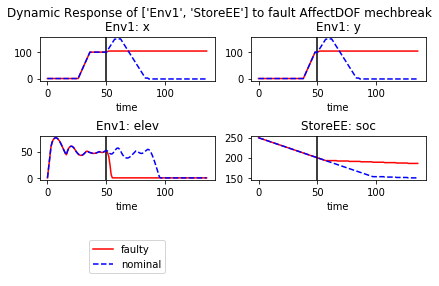

In [104]:
rd.plot.mdlhistvals(mdlhist,'AffectDOF mechbreak', time=50, fxnflowvals={'Env1':['x','y','elev'], 'StoreEE':['soc']})

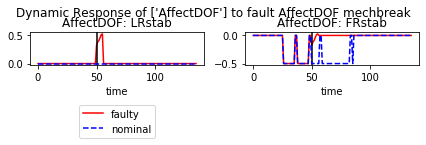

In [105]:
rd.plot.mdlhistvals(mdlhist,'AffectDOF mechbreak', time=50, fxnflowvals={'AffectDOF':['LRstab','FRstab']})

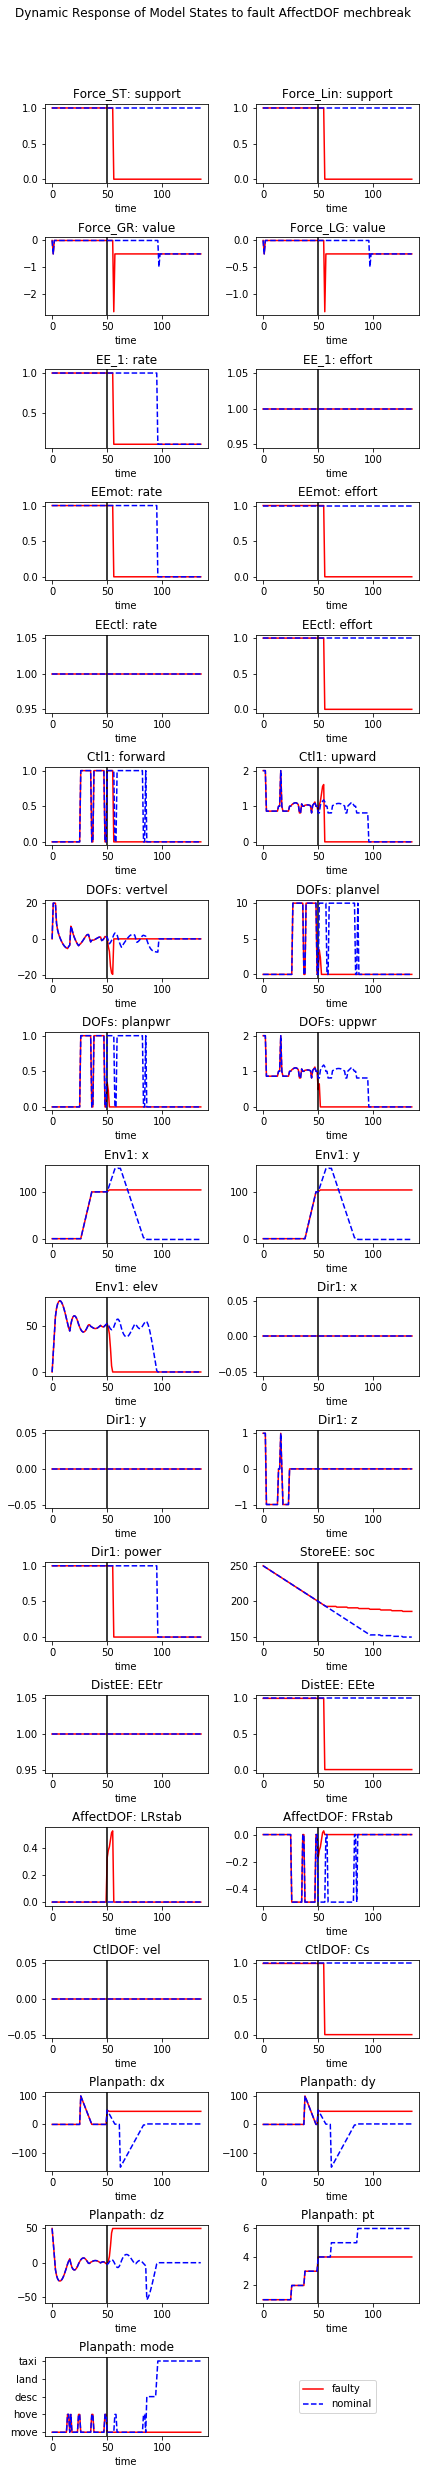

In [106]:
rd.plot.mdlhistvals(mdlhist,'AffectDOF mechbreak', time=50)

In [107]:
hierarchical_model = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'oct'})
endresults, resgraph, mdlhist = fs.propagate.one_fault(hierarchical_model,'AffectDOF', 'RFmechbreak', time=50)

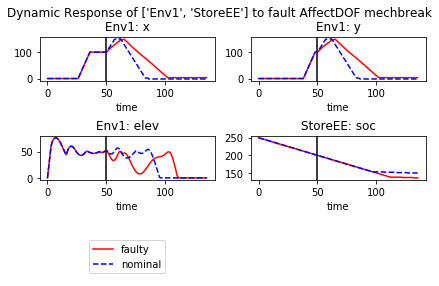

In [108]:
rd.plot.mdlhistvals(mdlhist,'AffectDOF mechbreak', time=50, fxnflowvals={'Env1':['x','y','elev'], 'StoreEE':['soc']})

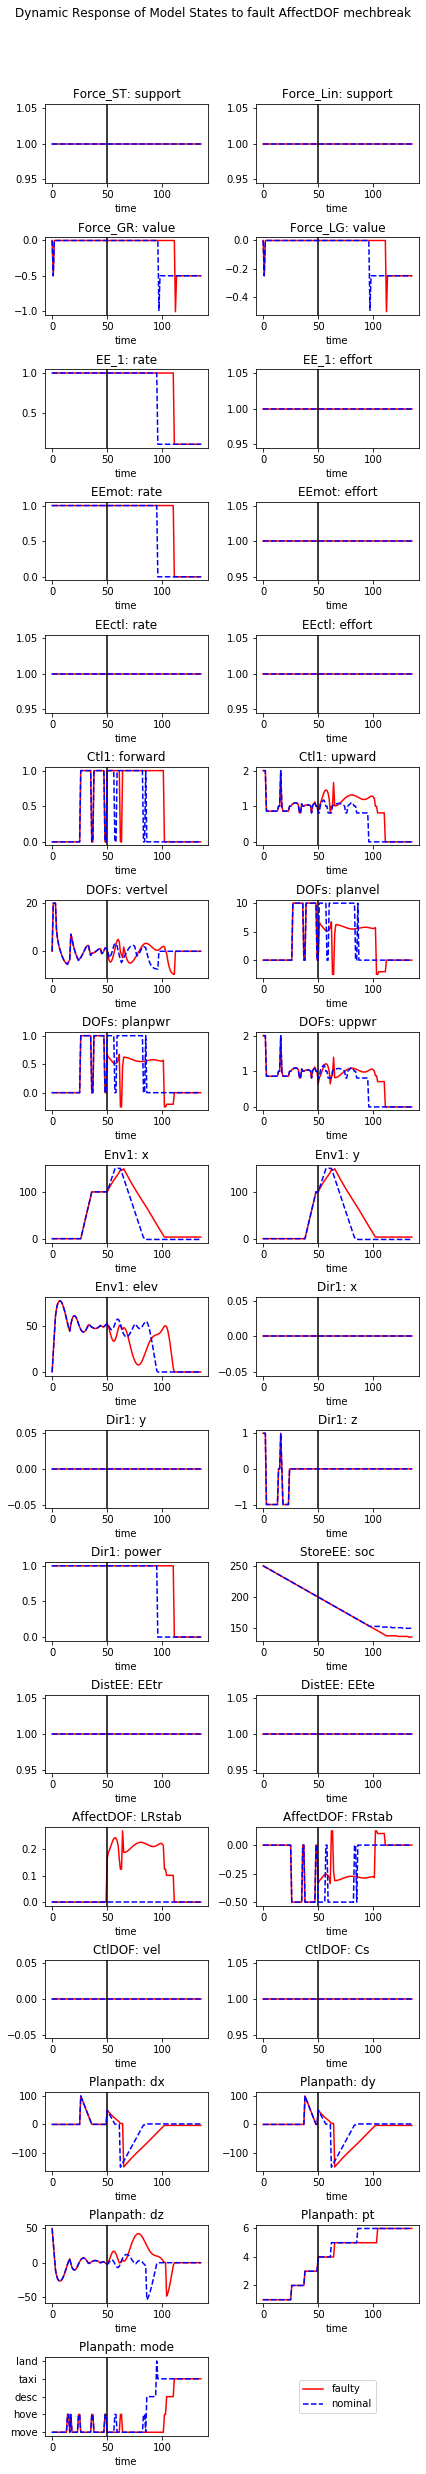

In [109]:
rd.plot.mdlhistvals(mdlhist,'AffectDOF mechbreak', time=50)

In [110]:
#mdl_quad = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'quad'})
#app_quad = SampleApproach(mdl_quad)

In [111]:
#endclasses_quad, mdlhists_quad = fs.propagate.approach(mdl_quad, app_quad)

In [112]:
#quad_tab = rd.tabulate.simplefmea(endclasses_quad)
#quad_tab.sort_values('expected cost', ascending=False)[:400]

,rate,cost,expected cost
"CtlDOF degctl, t=49.0",6.000000e-07,95800.0,5748.000000
"DistEE degr, t=49.0",4.166667e-07,86800.0,3616.666667
"Planpath degloc, t=49.0",6.000000e-07,60000.0,3600.000000
"StoreEE nocharge, t=49.0",3.125000e-07,86100.0,2690.625000
"DistEE short, t=49.0",2.500000e-07,88800.0,2220.000000
...,...,...,...
"AffectDOF LFpropstuck, t=97.0",1.388889e-09,200.0,0.027778
"AffectDOF LRpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF RRpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LFpropwarp, t=97.0",6.944444e-10,200.0,0.013889


In [113]:
mdl_quad = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'quad'})
mdl_quad.fxns['AffectDOF'].faultmodes
quad_faults = [('AffectDOF', fault) for fault in list(mdl_quad.fxns['AffectDOF'].faultmodes.keys())]

In [114]:
quad_app = SampleApproach(mdl_quad, faults=quad_faults)
quad_endclasses, quad_mdlhists = fs.propagate.approach(mdl_quad, quad_app, staged=True)

In [115]:
quad_tab = rd.tabulate.simplefmea(quad_endclasses)
quad_tab.sort_values('expected cost', ascending=False)

,rate,cost,expected cost
"AffectDOF LFctlbreak, t=49.0",1.666667e-07,86800.0,1446.666667
"AffectDOF RFctlbreak, t=49.0",1.666667e-07,86800.0,1446.666667
"AffectDOF RRctlbreak, t=49.0",1.666667e-07,86800.0,1446.666667
"AffectDOF LRctlbreak, t=49.0",1.666667e-07,86800.0,1446.666667
"AffectDOF LRctldn, t=49.0",1.666667e-07,86300.0,1438.333333
...,...,...,...
"AffectDOF RRpropstuck, t=97.0",1.388889e-09,200.0,0.027778
"AffectDOF LRpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF RFpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LFpropwarp, t=97.0",6.944444e-10,200.0,0.013889


In [116]:
quad_res = sum(quad_tab['expected cost'])
quad_res

31220.157407407427

In [117]:
mdl_oct = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'oct'})
mdl_oct.fxns['AffectDOF'].faultmodes
oct_faults = [('AffectDOF', fault) for fault in list(mdl_oct.fxns['AffectDOF'].faultmodes.keys())]

In [118]:
mdl_oct = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'oct'})

In [119]:
oct_app = SampleApproach(mdl_oct, faults=oct_faults)
oct_endclasses, oct_mdlhists = fs.propagate.approach(mdl_oct, oct_app)

In [120]:
oct_tab = rd.tabulate.simplefmea(oct_endclasses)
oct_tab.sort_values('expected cost', ascending=False)

,rate,cost,expected cost
"AffectDOF RF2ctlup, t=49.0",1.666667e-07,89100.0,1485.000000
"AffectDOF RFctlup, t=49.0",1.666667e-07,89100.0,1485.000000
"AffectDOF LF2ctlup, t=49.0",1.666667e-07,89100.0,1485.000000
"AffectDOF LFctlup, t=49.0",1.666667e-07,89100.0,1485.000000
"AffectDOF RR2short, t=49.0",8.333333e-08,91800.0,765.000000
...,...,...,...
"AffectDOF RFpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LFpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LF2propwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LR2propwarp, t=97.0",6.944444e-10,200.0,0.013889


In [121]:
oct_res = sum(oct_tab['expected cost'])
oct_res

21588.83333333336

In [66]:
oct_tab.sort_values('expected cost', ascending=False)[100:]

,rate,cost,expected cost
"AffectDOF RFctldn, t=84.0",2.944444e-07,500.0,14.722222
"AffectDOF LR2ctlup, t=84.0",2.944444e-07,500.0,14.722222
"AffectDOF LFctldn, t=84.0",2.944444e-07,500.0,14.722222
"AffectDOF RR2ctlup, t=84.0",2.944444e-07,500.0,14.722222
"AffectDOF LRctlup, t=84.0",2.944444e-07,500.0,14.722222
...,...,...,...
"AffectDOF LRpropwarp, t=169.0",1.527778e-09,200.0,0.030556
"AffectDOF RFpropwarp, t=169.0",1.527778e-09,200.0,0.030556
"AffectDOF RF2propwarp, t=169.0",1.527778e-09,200.0,0.030556
"AffectDOF RR2propwarp, t=169.0",1.527778e-09,200.0,0.030556


In [132]:
rd.tabulate.summfmea(quad_endclasses,quad_app).sort_values('expected cost', ascending=False)

rate          cost  expected cost
AffectDOF RFctlbreak      1.851852e-07  41533.333333    1481.666667
          RRctlbreak      1.851852e-07  41533.333333    1481.666667
          LFctlbreak      1.851852e-07  41533.333333    1481.666667
          LRctlbreak      1.851852e-07  41533.333333    1481.666667
          RRctlup         1.851852e-07  41033.333333    1472.407407
          LRctlup         1.851852e-07  41033.333333    1472.407407
          RFctlup         1.851852e-07  41033.333333    1472.407407
          LFctlup         1.851852e-07  41033.333333    1472.407407
          RRctldn         1.851852e-07  29433.333333    1440.185185
          LRctldn         1.851852e-07  29433.333333    1440.185185
          RFctldn         1.851852e-07  29100.000000    1439.259259
          LFctldn         1.851852e-07  29100.000000    1439.259259
          RRshort         9.259259e-08  44400.000000     762.129630
          RFshort         9.259259e-08  44400.000000     762.129630
          LFshort         9.259259e-08  44400.000000     762.129630
          LRshort         9.259259e-08  44400.000000     762.129630
          LRopenc         9.259259e-08  40733.333333     733.425926
          LFopenc         9.259259e-08  40733.333333     733.425926
          RRopenc         9.259259e-08  40733.333333     733.425926
          RFopenc         9.259259e-08  40733.333333     733.425926
          LFmechbreak     9.259259e-08  40700.000000     731.805556
          LRmechbreak     9.259259e-08  40700.000000     731.805556
          RFmechbreak     9.259259e-08  40700.000000     731.805556
          RRmechbreak     9.259259e-08  40700.000000     731.805556
          RFmechfriction  6.597222e-08  43400.000000     539.548611
          RRmechfriction  6.597222e-08  43400.000000     539.548611
          LFmechfriction  6.597222e-08  43400.000000     539.548611
          LRmechfriction  6.597222e-08  43400.000000     539.548611
          LFpropbreak     3.958333e-08  43000.000000     321.791667
          LRpropbreak     3.958333e-08  43000.000000     321.791667
          RFpropbreak     3.958333e-08  43000.000000     321.791667
          RRpropbreak     3.958333e-08  43000.000000     321.791667
          LFpropstuck     2.638889e-08  43100.000000     215.027778
          LRpropstuck     2.638889e-08  43100.000000     215.027778
          RFpropstuck     2.638889e-08  43100.000000     215.027778
          RRpropstuck     2.638889e-08  43100.000000     215.027778
          LFpropwarp      1.319444e-08  43100.000000     107.513889
          LRpropwarp      1.319444e-08  43100.000000     107.513889
          RFpropwarp      1.319444e-08  43100.000000     107.513889
          RRpropwarp      1.319444e-08  43100.000000     107.513889

In [134]:
rd.tabulate.summfmea(oct_endclasses,oct_app).sort_values('expected cost', ascending=False)[:40]

rate          cost  expected cost
AffectDOF RFctlup       1.851852e-07  42900.000000    1521.666667
          RF2ctlup      1.851852e-07  42900.000000    1521.666667
          LF2ctlup      1.851852e-07  42900.000000    1521.666667
          LFctlup       1.851852e-07  42900.000000    1521.666667
          RFshort       9.259259e-08  46266.666667     786.759259
          RRshort       9.259259e-08  46266.666667     786.759259
          RF2short      9.259259e-08  46266.666667     786.759259
          LRshort       9.259259e-08  46266.666667     786.759259
          LF2short      9.259259e-08  46266.666667     786.759259
          LR2short      9.259259e-08  46266.666667     786.759259
          LFshort       9.259259e-08  46266.666667     786.759259
          RR2short      9.259259e-08  46266.666667     786.759259
          LR2ctlup      1.851852e-07  30033.333333     698.888889
          RR2ctlup      1.851852e-07  30033.333333     698.888889
          LRctlup       1.851852e-07  30033.333333     698.888889
          RRctlup       1.851852e-07  30033.333333     698.888889
          RR2ctlbreak   1.851852e-07  14200.000000     662.777778
          RRctlbreak    1.851852e-07  14200.000000     662.777778
          LR2ctlbreak   1.851852e-07  14200.000000     662.777778
          LRctlbreak    1.851852e-07  14200.000000     662.777778
          RRopenc       9.259259e-08  13400.000000     323.981481
          LR2openc      9.259259e-08  13400.000000     323.981481
          LRopenc       9.259259e-08  13400.000000     323.981481
          RR2openc      9.259259e-08  13400.000000     323.981481
          RRmechbreak   9.259259e-08  13533.333333     322.592593
          LRmechbreak   9.259259e-08  13533.333333     322.592593
          RR2mechbreak  9.259259e-08  13533.333333     322.592593
          LR2mechbreak  9.259259e-08  13533.333333     322.592593
          LR2propbreak  3.958333e-08  19400.000000     144.791667
          RRpropbreak   3.958333e-08  19400.000000     144.791667
          LRpropbreak   3.958333e-08  19400.000000     144.791667
          RR2propbreak  3.958333e-08  19400.000000     144.791667
          LRpropstuck   2.638889e-08  19500.000000      97.027778
          RRpropstuck   2.638889e-08  19500.000000      97.027778
          LR2propstuck  2.638889e-08  19500.000000      97.027778
          RR2propstuck  2.638889e-08  19500.000000      97.027778
          LFctlbreak    1.851852e-07   1000.000000      18.518519
          RF2ctlbreak   1.851852e-07   1000.000000      18.518519
          RFctlbreak    1.851852e-07   1000.000000      18.518519
          LF2ctlbreak   1.851852e-07   1000.000000      18.518519

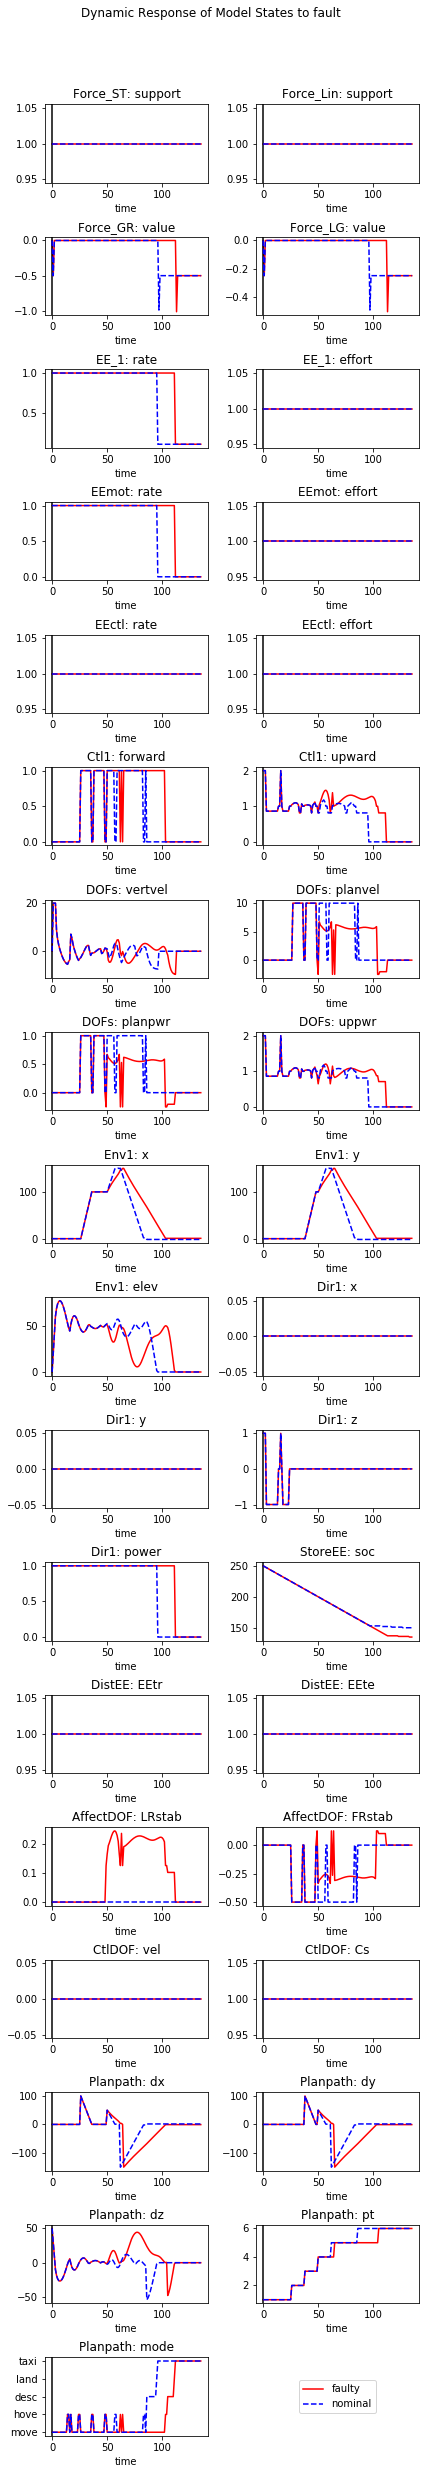

In [125]:
rd.plot.mdlhistvals({'nominal':oct_mdlhists['nominal'], 'faulty':oct_mdlhists['AffectDOF RFmechbreak, t=49.0']})

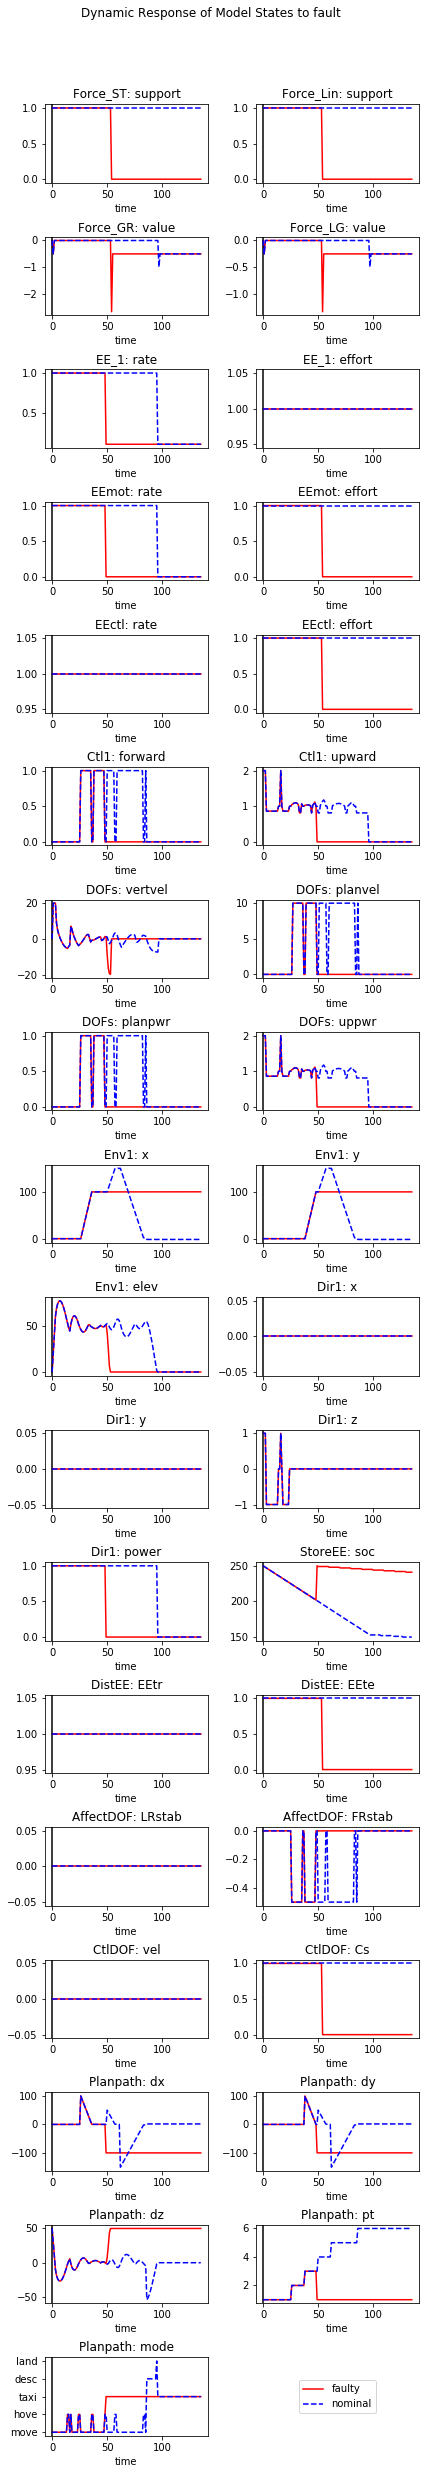

In [126]:
rd.plot.mdlhistvals({'nominal':quad_mdlhists['nominal'], 'faulty':quad_mdlhists['AffectDOF RFmechbreak, t=49.0']})

In [ ]:
rd.tabulate.phasefmea(quad_app, quad_endclasses)

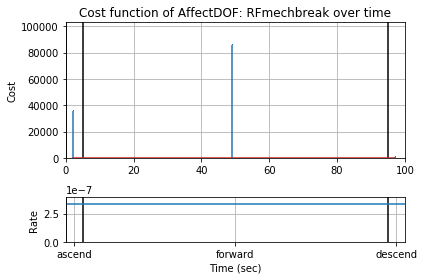

In [128]:
rd.plot.samplecost(quad_app, quad_endclasses, ('AffectDOF', 'RFmechbreak'))

In [ ]:
rd.plot.samplecost(quad_app, quad_endclasses, ('AffectDOF', 'RFmechbreak'))